# LightGBM模型

## LightGBM模型核心思想

**LightGBM（Light Gradient Boosting Machine）**模型是一种基于梯度提升框架的Boosting模型。LightGBM是基于XGBOOST模型设计的改进模型，相比于XGBOOST模型，LightGBM模型做了如下改进：
- **基于直方图的决策树学习**：
    - 在XGBOOST模型中，决策树的分裂是通过枚举所有特征值来寻找最佳分裂点，这对于大规模数据来说非常慢
    - 在 LightGBM 中，特征值被离散化为直方图桶，然后在直方图桶上寻找最佳分裂点。这样减少了特征值的处理次数，从而加快了训练速度，并降低了内存使用。
- **叶子优先的生长策略**：
    - XGBoost 使用层级优先（Level-wise）的树生长策略，即每次从当前树的每一层选择最佳的分裂点。这种策略生成的树通常较为平衡，树的深度较为均匀，但可能拟合度不如叶子优先
    - LightGBM 使用叶子优先（Leaf-wise）的生长策略，即每次选择当前树中残差最大的叶子进行分裂。这种策略能够更好地减少残差，因此通常会生成更深的树，从而能更好地拟合数据
    - 叶子优先策略相较于层级优先，在 减少残差上更有效，通常能够提高模型的精度，但也有可能导致过拟合。为此，LightGBM 提供了调节 最大深度（max_depth） 和 叶子节点最小样本数（min_data_in_leaf） 等超参数，以控制过拟合
- **更高效的类别特征处理方法**：
    - XGBoost 在处理类别特征时，需要先进行 one-hot 编码 或 整数编码。如果类别特征有大量的类别，one-hot 编码会导致特征维度的显著增加，从而增加计算复杂度和内存消耗
    - LightGBM 可以 直接处理类别特征，无需进行 one-hot 编码。它通过优化算法自动处理类别特征，这对于处理类别维度非常高的特征（如数百万个类别）非常有用，能够显著减少内存使用和提高训练效率
- **更高效的分布式训练**：
    - XGBoost支持数据并行和特征并行的分布式训练，能够在多台机器上分配任务进行计算，从而加速训练过程
    - LightGBM 在分布式训练上进行了进一步优化，也支持数据并行和特征并行，但是处理效率更高

## LightGBM模型主要步骤

LightGBM模型的主要步骤概括如下：

1. **初始化**：
    - 首先，LightGBM模型会用一个简单的模型（如常数模型）对所有样本做出初始预测。
2. **迭代优化**：
    - **计算梯度和二阶梯度**：基于当前模型的预测结果，计算每个样本的梯度（误差）和二阶梯度（误差变化率）。
    - **拟合决策树**：基于梯度和二阶梯度，将其作为目标变量来训练一棵决策树。LightGBM 使用 叶子优先（Leaf-wise） 的树生长策略，从残差最大的位置开始分裂，使得每棵树都能更好地拟合训练数据。
    - **更新预测**：将新训练的决策树加入到模型中，更新每个样本的预测值为原预测值加上新决策树的输出。
    - **重复上述过程**，直到达到预设的迭代次数或满足停止条件。
3. **构建最终模型**：
    - 所有决策树的加权预测结果组合起来，形成最终的强学习器。

## LightGBM模型优缺点

### LightGBM模型的优点

- **直方图算法效率高**：在 LightGBM 中，特征值被离散化为直方图桶，然后在直方图桶上寻找最佳分裂点。这样减少了特征值的处理次数，从而加快了训练速度，并降低了内存使用
- **叶子优先生长策略（Leaf-wise）**：LightGBM 使用叶子优先的策略，相比层级优先生长（Level-wise），它能更快地收敛并获得更低的训练误差，尤其在数据复杂度较高时表现出色
- **内置类别特征支持**：与其他梯度提升算法（如 XGBoost）不同，LightGBM 能够直接处理类别特征，无需进行 one-hot 编码或其他复杂预处理。这减少了特征空间的维度，避免了由于特征扩展造成的计算复杂度和内存消耗

### LightGBM模型的缺点

- **过拟合风险高**：相比于XGBOOST模型的层级优先生长策略，LightGBM模型所使用的叶子优先生长策略更容易生成深树，这会导致模型更容易捕获到数据中的噪声，导致过拟合。
- **对超参数调节敏感**：LightGBM模型的性能很大程度上依赖于 超参数调节。选择合适的学习率、树的深度、正则化参数等非常关键。如果调参不当，模型可能会过拟合或欠拟合。因此最好使用交叉验证或网格搜索等方法来帮助LightGBM模型选择最优超参数

# LightGBM模型案例（多分类）

## lightgbm模型参数

### params参数

- **objective**: 任务类型
    - 二分类: 'binary'
    - 多分类: 'multiclass'
    - 回归: 'regression'
    - 排序: 'lambdarank'
- **num_class**: 多分类类别数（仅多分类任务使用）。
- **metric**：评估指标
    - 二分类: 'auc'、'binary_logloss'
    - 多分类: 'multi_logloss'
    - 回归: 'rmse'（均方根误差RMSE）、'l1'（平均绝对误差MAE）、'l2'（均方误差MSE）、'mape'（平均绝对百分比误差MAPE）
- **max_depth**: 决策树的最大深度。控制模型复杂度，值越大模型越容易过拟合。
- **num_leaves**: 叶子节点数
- **min_data_in_leaf**: 叶子最小样本数。防止过拟合小样本。
- **learning_rate**: 学习率，控制每棵树对最终结果的影响，值越小训练越慢但更稳定。通常设置在 0.01 到 0.3 之间。  
- **feature_fraction**: 特征采样比例。
- **bagging_fraction**: 数据采样比例。
- **lambda_l1**: L1正则化系数。
- **lambda_l2**: L2正则化系数。
- **verbosity**: 控制训练过程输出。
    - 0：输出全部信息
    - 1：输出警告信息
    - 2：输出详细信息
    - 3：仅输出致命错误  
- **seed**: 随机数种子。

### lgb.train参数

- **params**: 2.1.1节中params参数，dict格式
- **train_set**: 训练数据，lightgbm.Dataset 格式，包含特征和标签。
- **num_boost_round**: 训练轮数，也即树的棵树。
- **valid_sets**: 验证集列表，验证集列表，用于监控模型效果。
- **valid_names**: 给验证集命名，和 valid_sets 一一对应。
- **feval**: 自定义评估函数，返回 (名称, 分数)，如 F1、精确率、召回率等。
- **init_model**: 是否从已有模型继续训练。
    - 已有模型路径
    - 已训练的 Booster 对象
    - None 表示从头开始
- **callbacks**: 回调函数:
    - lgb.early_stopping(stopping_rounds=xx): 设置早停步数
    - lgb.log_evaluation(period=xx): 每隔 xx 次打印一次日志
    - lgb.record_evaluation(eval_result_dict): 将每轮评估结果保存到字典中

## 手写数字识别digits数据集

digits数据集是一个经典的手写数字图像识别数据集，任务是根据图像的特征预测图像所代表的数字标签
- 这个数据集总共有1797个图像样本：
    - 每个图像是一个 8x8 的灰度图像，其每个像素的灰度值范围为 0 到 16，表示黑色（0）到白色（16）。这些图像已经被展平为 64 维的向量，因此每个图像可以表示为一个长度为 64 的向量
    - 数字标签的范围是从 0 到 9，对应的是手写数字
- 这个数据集由以下组成
    - data：一个数组，形状为 (1797, 64)，每一行表示一个 8x8 图像的特征（64个像素值，表示灰度强度）。
    - target：一个数组，形状为 (1797,)，每个元素表示相应图像的标签（0到9之间的数字）。
    - target_names：一个数组，表示数字标签的类别名，通常是 [0, 1, 2, ..., 9]。
    - images：一个数组，形状为 (1797, 8, 8)，每个元素是一个 8x8 的数字图像矩阵。
    - DESCR：一个字符串，包含数据集的描述信息。

In [1]:
# 导入必要的库
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import pandas as pd
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 加载 digits 数据集
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

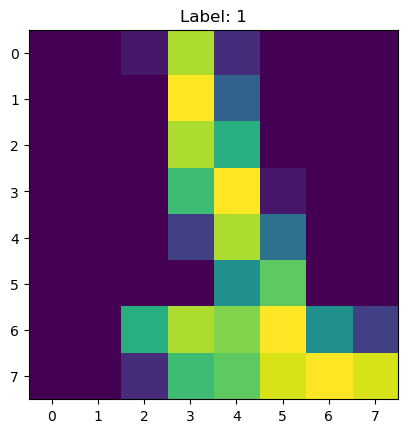

In [2]:
# 绘制数字图像
idx=1000
plt.imshow(digits.images[idx])
plt.title(f'Label: {digits.target[idx]}')
plt.show()

## 代码实现

lightgbm版本必须是4.6.0，否则可能报错

Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.233235	valid's multi_logloss: 0.324056
[100]	train's multi_logloss: 0.0362351	valid's multi_logloss: 0.126433
[150]	train's multi_logloss: 0.00902792	valid's multi_logloss: 0.084546
[200]	train's multi_logloss: 0.0041507	valid's multi_logloss: 0.0704923
[250]	train's multi_logloss: 0.00284096	valid's multi_logloss: 0.0652517
[300]	train's multi_logloss: 0.00258607	valid's multi_logloss: 0.064531
[350]	train's multi_logloss: 0.00257755	valid's multi_logloss: 0.0645212
[400]	train's multi_logloss: 0.00257733	valid's multi_logloss: 0.0645177
[450]	train's multi_logloss: 0.00257728	valid's multi_logloss: 0.0645174
[500]	train's multi_logloss: 0.00257725	valid's multi_logloss: 0.0645174
[550]	train's multi_logloss: 0.00257724	valid's multi_logloss: 0.0645174
[600]	train's multi_logloss: 0.00257724	valid's multi_logloss: 0.0645174
[650]	train's multi_logloss: 0.00257724	valid's multi_logloss: 0.0645174

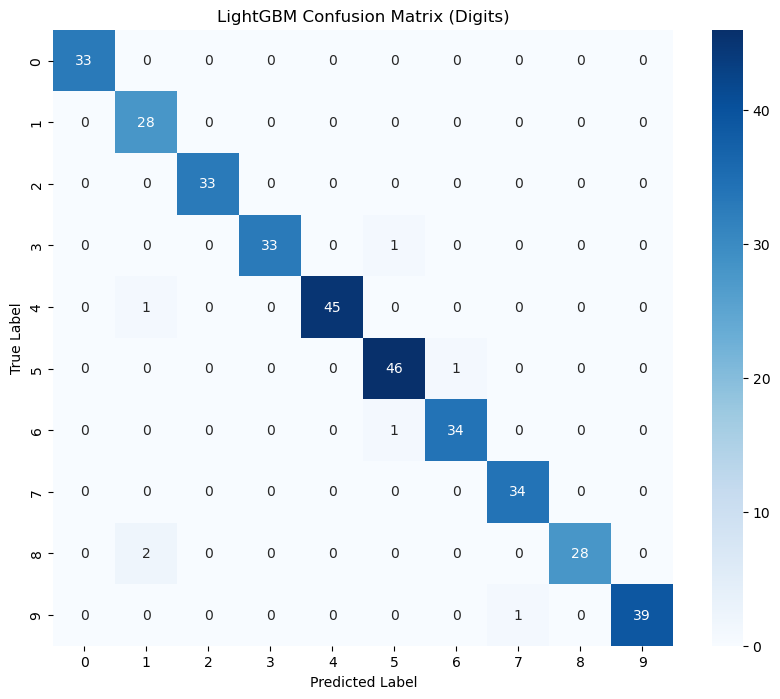

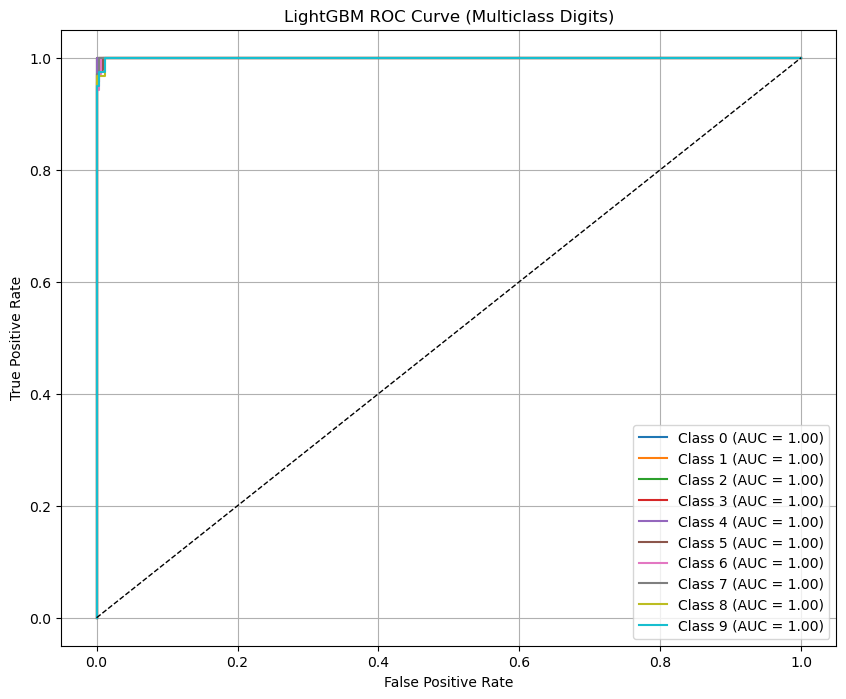

In [3]:
# ============ 1. 导入库 ============
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ============ 2. 加载数据 ============
digits = load_digits()  # 加载手写数字数据集
X = digits.data         # 特征数据（64维，8x8图像展平）
y = digits.target       # 标签数据（0-9）
class_names = digits.target_names  # 类别名称 [0,1,...,9]

# ============ 3. 数据划分 ============
# 使用分层抽样划分训练集和验证集（保持类别分布）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # 验证集占比20%
    random_state=42,     # 随机种子保证可复现
)

# ============ 4. 构建LightGBM数据集 ============
dtrain = lgb.Dataset(X_train, label=y_train)  # 训练集
dtest = lgb.Dataset(                          # 验证集
    X_test, 
    label=y_test
)

# ============ 5. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'multiclass',   # 多分类任务
    'num_class': 10,            # 类别数（0-9共10类）
    'metric': 'multi_logloss',   # 多分类对数损失
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 30, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.001,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}


# ============ 6. 模型训练 ============
lgb_clf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=50)            # 每50轮打印一次日志
    ]
)

# ============ 7. 模型预测 ============
# 预测每个样本属于各类别的概率（shape: [n_samples, 10]）
y_prob = lgb_clf.predict(X_test)

# 取概率最大的类别作为预测结果
y_pred = np.argmax(y_prob, axis=1)

# ============ 8. 评估指标 ============
# 打印分类报告（精确率、召回率、F1等）
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ============ 9. 可视化分析 ============
# (1) 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True,            # 显示数值
    fmt="d",               # 整数格式
    cmap="Blues",          # 颜色映射
    xticklabels=class_names,  # x轴类别标签
    yticklabels=class_names   # y轴类别标签
)
plt.title("LightGBM Confusion Matrix (Digits)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# (2) 多类别ROC曲线
# 将真实标签二值化（one-hot编码）
y_test_bin = label_binarize(y_test, classes=class_names)
n_classes = len(class_names)  # 类别数（10）

# 存储每类的FPR、TPR和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# 计算每个类别的ROC曲线
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制多类ROC曲线
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)  # 使用10种颜色

for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f'Class {i} (AUC = {roc_auc[i]:.2f})',
        color=colors(i)
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # 绘制对角线（随机猜测）
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM ROC Curve (Multiclass Digits)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# LightGBM可视化

## lgb_plot.plot_tree

**lgb_plot.plot_tree**: 生成直观的LightGBM树形结构图
- `booster`: 训练好的LightGBM模型
- `tree_index`: 要绘制第几棵树（从 0 开始），可用循环遍历多棵树
- `figsize`: 图的宽高，单位为英寸
- `dpi`: 分辨率（每英寸点数）
- `show_info`: 要在节点中显示的附加信息，可选值如下：
    - "split_gain"：增益
    - "internal_value"：节点的值
    - "internal_count"：内部节点样本数
    - "leaf_count"：叶子节点样本数
- `precision`: 小数显示的精度（默认保留3位）
- `orientation`: 决定图的布局方向：
    - `horizontal`：从上到下（默认）
    - `vertical`：从左到右（推荐更清晰）

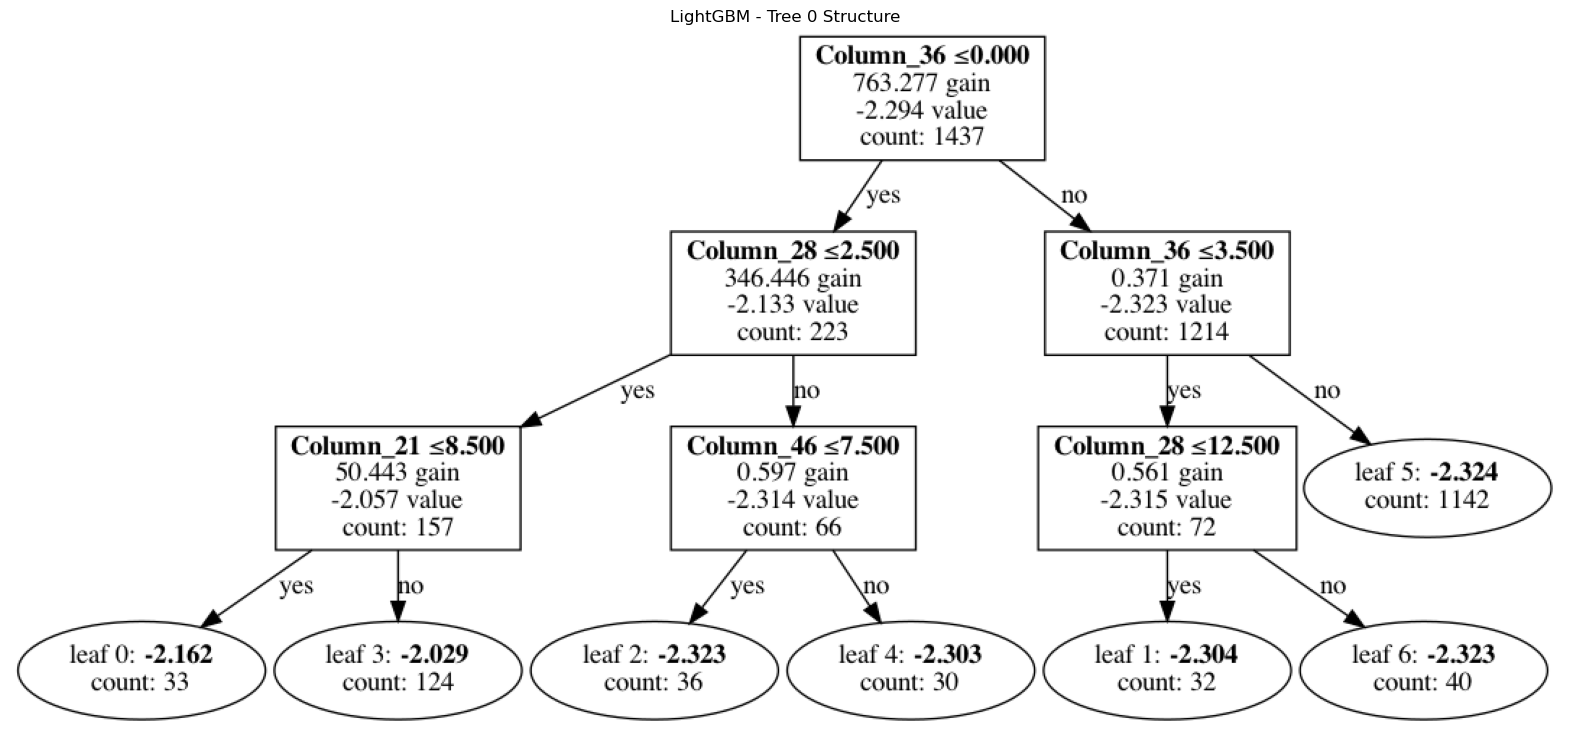

In [4]:
import graphviz
import lightgbm.plotting as lgb_plot
from IPython.display import display

# 可视化第0棵树（可以改成其他编号）
lgb_plot.plot_tree(
    booster=lgb_clf,
    tree_index=0,
    figsize=(20, 10),
    show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
    orientation='vertical'
)
plt.title("LightGBM - Tree 0 Structure")
plt.show()

# 特征重要度

在 LightGBM 中，**特征重要性（Feature Importance）** 是衡量每个特征在模型构建中贡献程度的重要指标。由于 LightGBM 是基于 **梯度提升框架** 的 **基于叶子的决策树模型（Leaf-wise Tree）**，它通过最小化损失函数迭代构建树，因此可以记录每个特征在模型训练过程中的“使用次数”、“信息增益”等指标，来衡量其重要性。

## LightGBM 中的特征重要性计算方式

LightGBM 提供 两种主流的特征重要性指标：

| 指标类型    | 含义说明                        |
| ------- | --------------------------- |
| `split` | 特征被用作节点划分的次数（频率）            |
| `gain`  | 使用该特征划分节点所带来的损失函数下降总量（信息增益） |


## split（分裂频次 / 使用次数）

- **定义**：某特征在所有树中被用作分裂节点的次数总和。 
    - 如果一个特征频繁出现在树的节点中，说明它对树的划分有广泛的贡献。 
    - 但它不考虑每次分裂的“质量”（是否带来显著增益）。 
- **计算公式**：
$$\text{Importance}_j^{(\text{weight})} = \sum_{m=1}^{M} \sum_{t \in T_m} \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 简单直观，易于解释。 
- **缺点**：
    - 可能会高估“常被选中但增益较低”的特征。 
    - 不考虑特征实际提升模型性能的程度。 
- **适合场景**：
    - 初步筛选特征（例如是否经常被使用）。 

## gain（平均信息增益，推荐）

- **定义**：某特征被用来分裂时，对模型损失函数（如 logloss, mse）带来的平均下降量（即平均提升）。 
    - 更关注“质量”而不是“次数”，代表该特征“每次使用是否有价值”。 
    - 通常是更可靠的特征重要性衡量标准。 
- **计算公式**：
$$\text{Importance}_j^{(\text{gain})} = \sum_{m=1}^{M} \sum_{t \in T_m} \Delta \mathcal{L}_t \cdot \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\Delta \mathcal{L}_t$：节点$t$分裂带来的 损失函数下降（loss reduction）
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 与模型性能直接相关。 
    - 强调了特征的“实际贡献”。 
- **缺点**：
    - 在样本不平衡或分裂稳定性差时可能波动较大。 
- **适合场景**：
    - 高质量特征排序、模型解释、业务特征分析。 

## 特征重要度代码实现与可视化

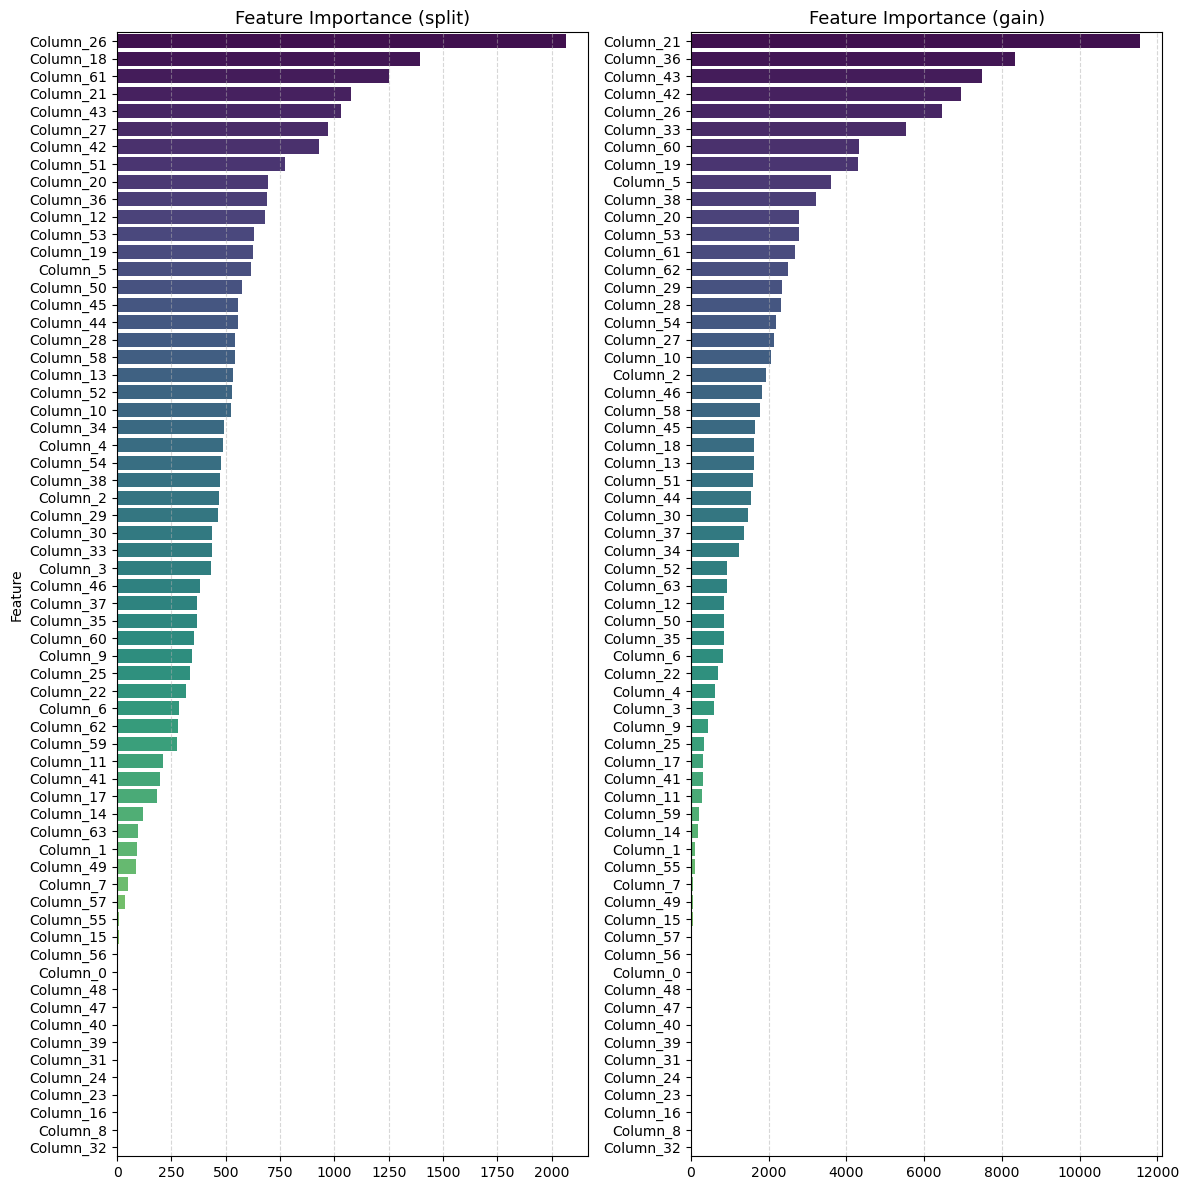

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置特征重要性类型：分裂次数、增益
importance_types = ['split', 'gain']
importance_data = {}

# 获取特征名称列表（对应训练时的列名）
feature_names = lgb_clf.feature_name()

# 遍历每种特征重要性类型
for imp_type in importance_types:
    # 获取指定类型的重要性值（返回的是按特征顺序的数组）
    importances = lgb_clf.feature_importance(importance_type=imp_type)

    # 构建 DataFrame：列为“特征名”和对应的重要性数值
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)  # 按重要性降序排列

    # 存储到字典中备用（可同时画多个子图）
    importance_data[imp_type] = imp_df

# 创建一个横排的 1 行 2 列图像区域
fig, axes = plt.subplots(1, 2, figsize=(12, 12))

# 遍历 importance_types 及其对应子图坐标
for i, imp_type in enumerate(importance_types):
    # 使用 seaborn 绘制水平条形图（左侧为特征名）
    sns.barplot(
        ax=axes[i],                                # 对应子图坐标
        data=importance_data[imp_type],            # 对应数据
        x='Importance',                            # 横坐标：重要性数值
        y='Feature',                               # 纵坐标：特征名称
        palette='viridis'                          # 使用 viridis 调色板
    )
    # 设置子图标题
    axes[i].set_title(f'Feature Importance ({imp_type})', fontsize=13)

    # 隐藏 x 轴标签（横坐标本身已表达含义）
    axes[i].set_xlabel('')
    
    # 除第一个子图外都隐藏 y 轴标签（节省空间）
    axes[i].set_ylabel('Feature' if i == 0 else '')

    # 添加网格线（横向，增强可读性）
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.5)

# 自动调整子图间距，防止重叠
plt.tight_layout()

# 展示最终图像
plt.show()